In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tiffile as tf

In [2]:
ROOT = "D:/workspace/dataset/Public/DataScienceBowl2018"
train_df = pd.read_csv(ROOT + "/train.csv")
display(train_df.head(2))
print(f'Train data shape: {train_df.shape}')

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


Train data shape: (73585, 9)


In [3]:
print(f'Unique id: {len(set(train_df.id))}')
# Let's take the first image as an example
train_df["id"].iloc[0]

Unique id: 606


'0030fd0e6378'

In [11]:
img_id = train_df.iloc[0]["id"]
print(img_id)
img = cv2.imread(f'{ROOT}/images/{img_id}.png')
# cv2.imshow("img", img)

0030fd0e6378


In [5]:
cls_map = {value:idx for idx,value in enumerate(train_df["cell_type"].unique())}
cls_map

{'shsy5y': 0, 'astro': 1, 'cort': 2}

In [6]:
def get_targets_mask(df, img_id):
    """
    Function to get target masks
    
    rles contains mask's description
    """
    targets = df[df["id"] == img_id]["cell_type"].apply(lambda x: cls_map[x]).values 
    rles = df[df["id"] == img_id]["annotation"].values
    
    return targets, rles

In [7]:
# Look at the number of labels, rles
labels, rles = get_targets_mask(train_df, img_id)
len(rles)

395

In [8]:
def decode_rle_mask(rle_mask, shape=(520, 704)):

    """
    Decode run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    rle_mask (str): Run-length encoded segmentation mask string
    rle_mask - it is a string with start and length coordinate values
    
    shape (tuple): Height and width of the mask

    Returns
    -------
    mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    # Transform mask value (necessary step before Image augmentation)
    mask = np.uint8(mask)
    
    return mask

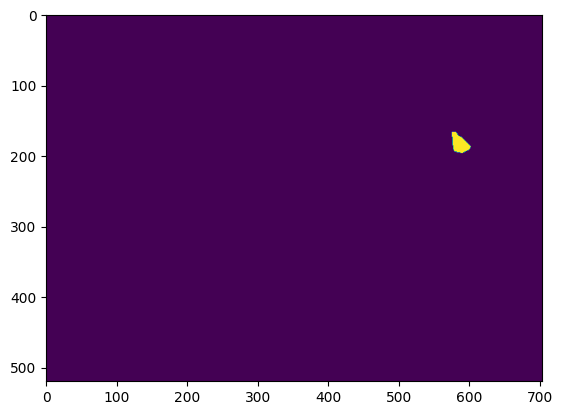

In [9]:
"""
How does work encode_rle_mask() function?

There is a mask of one object at the image
"""
mask_ex = decode_rle_mask(rles[0])
plt.imshow(mask_ex)

In [12]:
#  Let's create masks
masks = []

for mask in train_df.loc[train_df['id'] == img_id, 'annotation'].values:
    decoded_mask = decode_rle_mask(rle_mask=mask, shape=img.shape)
    
    masks.append(decoded_mask)
len(masks)

395

In [13]:
mask_all = None
for i, mask in enumerate(masks):
    if i == 0:
        mask_all = mask
    else:
        mask_all += mask

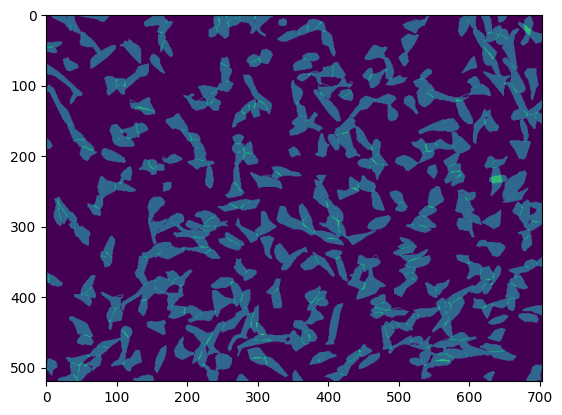

In [14]:
plt.imshow(mask_all)

In [15]:
print(mask_all)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [16]:
for img_id in set(train_df.id):
    masks = []

    for mask in train_df.loc[train_df['id'] == img_id, 'annotation'].values:
        decoded_mask = decode_rle_mask(rle_mask=mask, shape=img.shape)
        
        masks.append(decoded_mask)

    mask_all = None
    for i, mask in enumerate(masks):
        if i == 0:
            mask_all = mask
        else:
            mask_all += mask
    
    tf.imsave(f'{ROOT}/labels/{img_id}.tiff', mask_all)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35280\4206205562.py:16: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tf.imsave(f'{ROOT}/labels/{img_id}.tiff', mask_all)
